# Importing Libraries

In [2]:
from IPython.display import clear_output

In [5]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.6 MB/s eta 0:00:00


In [3]:
import zipfile
import os
from copy import deepcopy


from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms


import numpy as np
import random
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import torchvision.models as models


import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [8]:
import os
from PIL import Image
import imagehash

def ExtractZipFile(zip_path):
    # zip_path = 'RoboticArmDataset.zip'  # Path to your ZIP file
    extract_path = 'datasets/'  # Directory to extract the dataset

    # Unzip the dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Verify the contents of the extracted directory
    print("Extracted files:", os.listdir(extract_path))

def find_similar_images(image_folder, hash_size=8, threshold=5):
    hashes = {}
    duplicates = []

    for filename in os.listdir(image_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):  # Add more extensions as needed
            filepath = os.path.join(image_folder, filename)
            image = Image.open(filepath)
            image_hash = imagehash.average_hash(image, hash_size=hash_size)
            similar_found = False

            for stored_hash, stored_filepath in hashes.items():
                if image_hash - stored_hash < threshold:
                    duplicates.append(filepath)
                    similar_found = True
                    break

            if not similar_found:
                hashes[image_hash] = filepath

    return duplicates

ExtractZipFile('TestV4.zip')
dataset_path = 'datasets/TestV4'
# Usage
duplicates = find_similar_images(dataset_path)

# Remove duplicates and count the number of deleted images
deleted_count = 0
for filepath in duplicates:
    os.remove(filepath)
    deleted_count += 1
    print(f"Removed similar image: {filepath}")

print(f"Total number of deleted images: {deleted_count}")


BadZipFile: File is not a zip file

# Data Loading and Preparing

In [ ]:
zip_path = 'RoboticArmDataset.zip'  # Path to your ZIP file
extract_path = 'datasets/'  # Directory to extract the dataset

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the contents of the extracted directory
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['RoboticArmDataset', 'Train', 'Test']


In [ ]:
class RoboticArmDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Create a label encoder
        self.label_encoder = LabelEncoder()

        # Populate image paths and labels
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                self.image_paths.append(image_path)
                self.labels.append(label)

        # Fit the label encoder
        self.labels = self.label_encoder.fit_transform(self.labels)

        # Store class mappings
        self.class_mapping = dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))

        # Print class mappings
        for class_name, class_id in self.class_mapping.items():
            print(f'{class_name} ---> {class_id}')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
# Define the transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a smaller size if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Create the dataset and DataLoader
dataset = RoboticArmDataset(folder_path='datasets/RoboticArmDataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


# Print the number of samples and a batch to verify
print("\nNumber of samples:", len(dataset))
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)


E Down max, warning-samples ---> 0
E up max warning-samples ---> 1
S down max, warning-samples ---> 2
S up max, warning-samples ---> 3
initial, Safe -samples ---> 4

Number of samples: 8914
Batch shape: torch.Size([32, 3, 224, 224])


In [ ]:
dataset_size = len(dataset)

# Define the split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verify the number of samples in each set
print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))


Training set size: 6239
Validation set size: 1337
Test set size: 1338


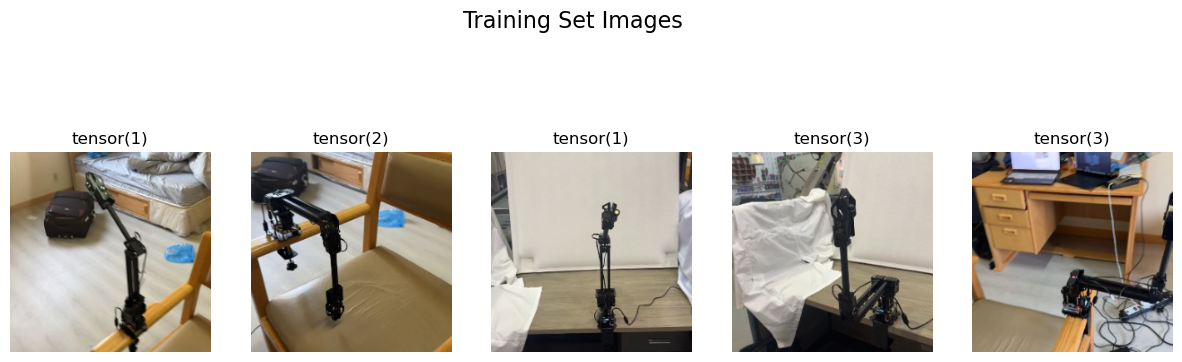

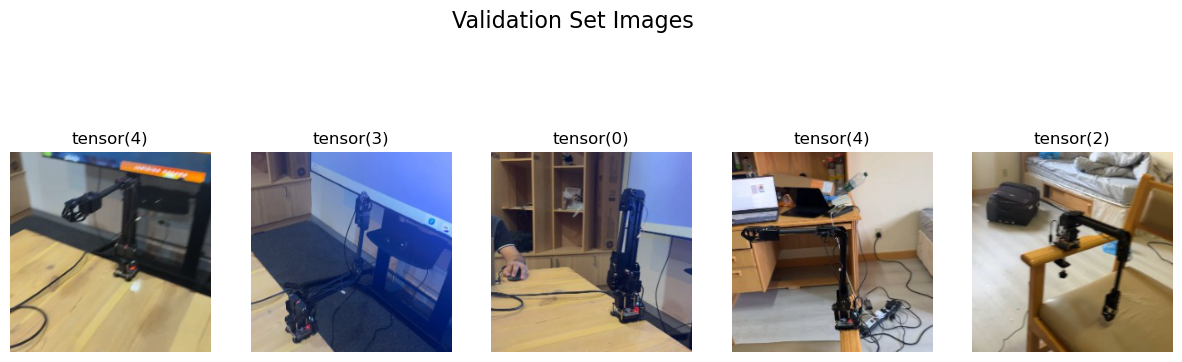

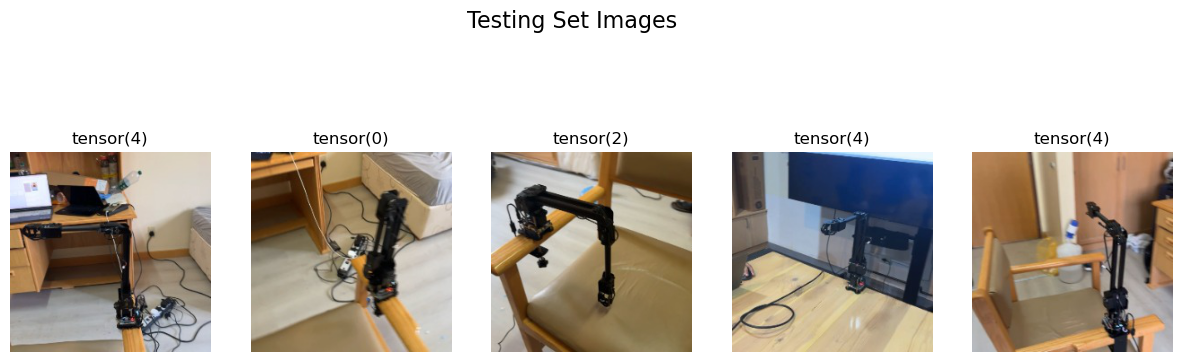

In [ ]:
# Function to display a batch of images with labels
def show_images(dataloader, title):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Create a grid of images
    fig, axes = plt.subplots(1, min(len(images), 5), figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(min(len(images), 5)):  # Display first 5 images
        image = images[i].permute(1, 2, 0)  # Reorder dimensions for plotting
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.numpy()
        label = labels[i]

        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()

# Display images from the training set
show_images(train_loader, "Training Set Images")

# Display images from the validation set
show_images(val_loader, "Validation Set Images")

# Display images from the testing set
show_images(test_loader, "Testing Set Images")

# Defining Necessary Function for Training and Testing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'the device is {device}')

the device is cuda


In [ ]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs):

    train_losses = []
    val_losses = []
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(epochs):

        train_loss = 0
        val_loss = 0

        ### Training
        model.train()
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y.squeeze())

            # Check if loss has a grad_fn
            assert loss.requires_grad, "Loss tensor does not require gradients"

            loss.backward()
            optimizer.step()
            train_loss += loss.item()*x.size(0)

        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)


        ### Validation
        model.eval()
        corrects = 0
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y.squeeze())
            val_loss += loss.item()*x.size(0)

            #calculate the number of correct predictions
            corrects += torch.sum(torch.argmax(output, dim=1) == y.squeeze()).item()
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {accuracy:.4f}')

        #if the model performs better on the validation set, save the model parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_params = deepcopy(model.state_dict())


    print(f'\n\nFinished Training and the best accuracy is: {best_accuracy*100:.4f}')
    return train_losses, val_losses, best_model_params, best_accuracy

In [ ]:
#confusion matrix function
def plot_cm(model, dl, categories, normalize='true'):
    #plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)

        output = model(x) #out shape: (batch_size, 5)
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    sns.heatmap(cm, annot=True, fmt= '.2f', cmap='Reds', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=categories.values()))


classes_names = {0: 'E Down', 1: 'E Up Max', 2: 'S Down Max', 3: 'S Up Max', 4: 'Initial'}

# ResNet-18

## ResNet18 Training

In [ ]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet18.fc = nn.Linear(512, 5)
resnet18.to(device)

Using cache found in /home/fallathh/.cache/torch/hub/pytorch_vision_v0.10.0
/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.3, verbose=True)

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(resnet18, criterion, optimizer, train_loader, val_loader, 10)

Epoch 1/10 | Train Loss: 0.1523 | Val Loss: 0.0608 | Val Accuracy: 0.9791
Epoch 2/10 | Train Loss: 0.0744 | Val Loss: 0.0542 | Val Accuracy: 0.9835
Epoch 3/10 | Train Loss: 0.0147 | Val Loss: 0.0157 | Val Accuracy: 0.9948
Epoch 4/10 | Train Loss: 0.0250 | Val Loss: 0.0222 | Val Accuracy: 0.9910
Epoch 5/10 | Train Loss: 0.0163 | Val Loss: 0.0060 | Val Accuracy: 0.9978
Epoch 6/10 | Train Loss: 0.0375 | Val Loss: 0.3725 | Val Accuracy: 0.8893
Epoch 7/10 | Train Loss: 0.0380 | Val Loss: 0.0139 | Val Accuracy: 0.9948
Epoch 8/10 | Train Loss: 0.0107 | Val Loss: 0.0041 | Val Accuracy: 0.9985
Epoch 9/10 | Train Loss: 0.0011 | Val Loss: 0.0047 | Val Accuracy: 0.9978
Epoch 10/10 | Train Loss: 0.0045 | Val Loss: 0.0028 | Val Accuracy: 0.9985


Finished Training and the best accuracy is: 99.8504


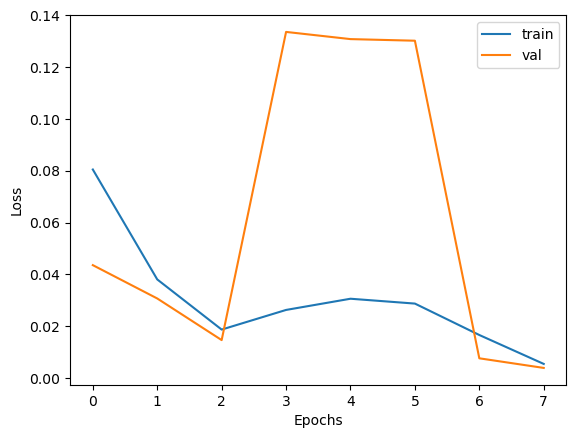

In [ ]:
#plot the training and validation losses
train_losses1 = train_losses

plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

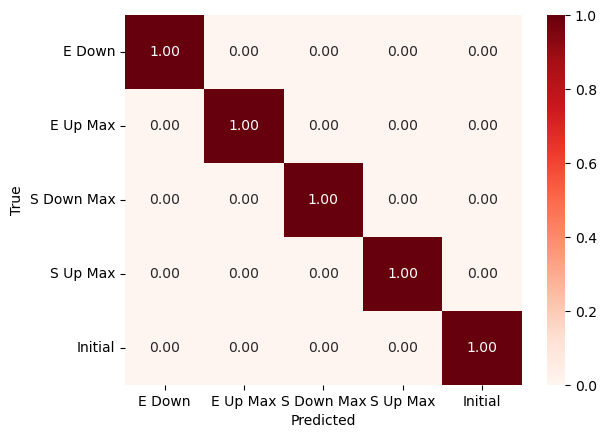

              precision    recall  f1-score   support

      E Down       1.00      1.00      1.00       294
    E Up Max       1.00      1.00      1.00       258
  S Down Max       1.00      1.00      1.00       152
    S Up Max       1.00      1.00      1.00       290
     Initial       1.00      1.00      1.00       343

    accuracy                           1.00      1337
   macro avg       1.00      1.00      1.00      1337
weighted avg       1.00      1.00      1.00      1337



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(resnet18, val_loader, classes_names)

## ResNet18 Testing



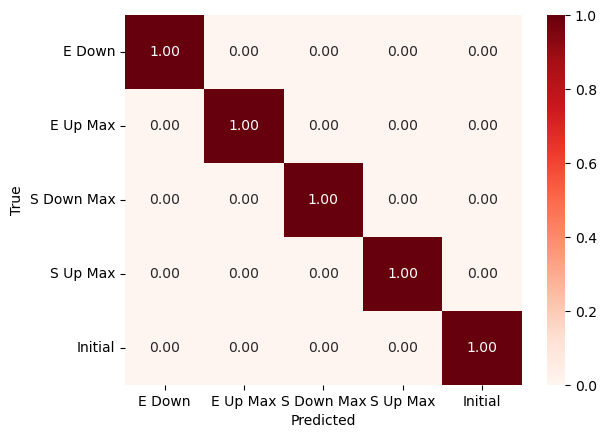

              precision    recall  f1-score   support

      E Down       1.00      1.00      1.00       293
    E Up Max       1.00      1.00      1.00       260
  S Down Max       1.00      1.00      1.00       156
    S Up Max       1.00      1.00      1.00       287
     Initial       1.00      1.00      1.00       342

    accuracy                           1.00      1338
   macro avg       1.00      1.00      1.00      1338
weighted avg       1.00      1.00      1.00      1338



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(resnet18, test_loader, classes_names)

# DenseNet-121

## DenseNet-121 Training

In [ ]:
# Load the pre-trained DenseNet model
DenseNet121 = models.densenet121(pretrained=True)

# Replace the final classification layer
num_ftrs = DenseNet121.classifier.in_features
DenseNet121.classifier = nn.Linear(num_ftrs, 5)

/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers
for param in DenseNet121.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in DenseNet121.classifier.parameters():
    param.requires_grad = True

DenseNet121 = DenseNet121.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet121.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(DenseNet121, criterion, optimizer, train_loader, val_loader, 10)

Epoch 1/10 | Train Loss: 1.3775 | Val Loss: 1.1175 | Val Accuracy: 0.7442
Epoch 2/10 | Train Loss: 1.0024 | Val Loss: 0.8606 | Val Accuracy: 0.8265
Epoch 3/10 | Train Loss: 0.8017 | Val Loss: 0.7015 | Val Accuracy: 0.8624
Epoch 4/10 | Train Loss: 0.6779 | Val Loss: 0.6046 | Val Accuracy: 0.8743
Epoch 5/10 | Train Loss: 0.5988 | Val Loss: 0.5379 | Val Accuracy: 0.8878
Epoch 6/10 | Train Loss: 0.5251 | Val Loss: 0.4878 | Val Accuracy: 0.8901
Epoch 7/10 | Train Loss: 0.4795 | Val Loss: 0.4465 | Val Accuracy: 0.9035
Epoch 8/10 | Train Loss: 0.4472 | Val Loss: 0.4120 | Val Accuracy: 0.9080
Epoch 9/10 | Train Loss: 0.4139 | Val Loss: 0.3837 | Val Accuracy: 0.9110
Epoch 10/10 | Train Loss: 0.3853 | Val Loss: 0.3668 | Val Accuracy: 0.9117


Finished Training and the best accuracy is: 91.1743


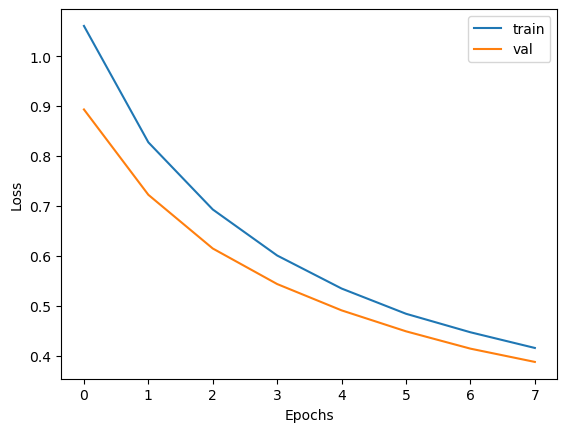

In [ ]:
#plot the training and validation losses
train_losses2 = train_losses

plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

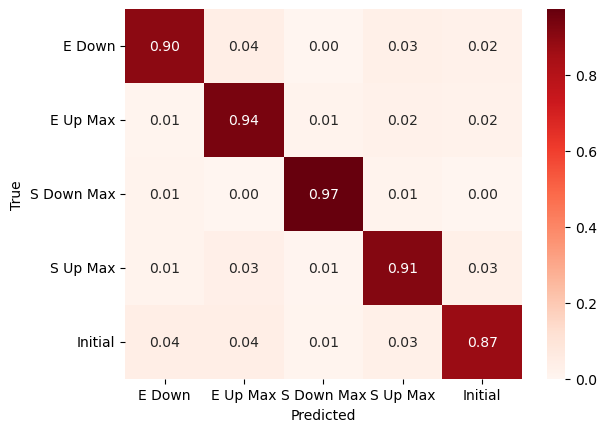

              precision    recall  f1-score   support

      E Down       0.92      0.90      0.91       294
    E Up Max       0.86      0.94      0.90       258
  S Down Max       0.95      0.97      0.96       152
    S Up Max       0.90      0.91      0.91       290
     Initial       0.93      0.87      0.90       343

    accuracy                           0.91      1337
   macro avg       0.91      0.92      0.92      1337
weighted avg       0.91      0.91      0.91      1337



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(DenseNet121, val_loader, classes_names)

## DenseNet-121 Testing

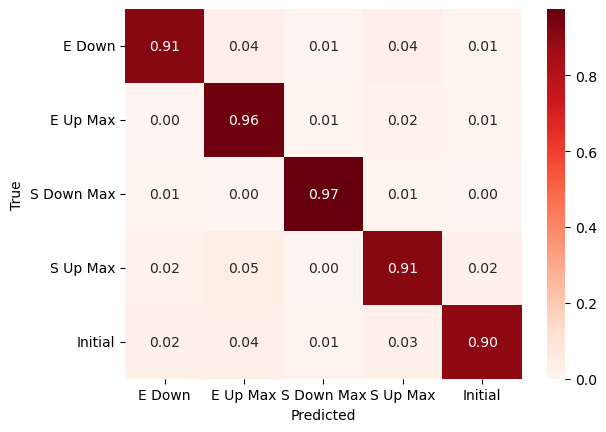

              precision    recall  f1-score   support

      E Down       0.94      0.91      0.92       293
    E Up Max       0.87      0.96      0.91       260
  S Down Max       0.94      0.97      0.96       156
    S Up Max       0.91      0.91      0.91       287
     Initial       0.96      0.90      0.93       342

    accuracy                           0.92      1338
   macro avg       0.92      0.93      0.93      1338
weighted avg       0.92      0.92      0.92      1338



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(DenseNet121, test_loader, classes_names)

# EfficientNet-B0

## EfficientNet-B0 Training

In [ ]:
# Load the pre-trained EfficientNet model
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

# Replace the final classification layer
num_ftrs = efficientnet_b0.classifier[1].in_features
efficientnet_b0.classifier[1] = nn.Linear(num_ftrs, 5)

In [ ]:
# Freeze all layers
for param in efficientnet_b0.parameters():
    param.requires_grad = False

# Unfreeze the final classification layer
for param in efficientnet_b0.classifier[1].parameters():
    param.requires_grad = True

efficientnet_b0 = efficientnet_b0.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_b0.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(efficientnet_b0, criterion, optimizer, train_loader, val_loader, 10)

Epoch 1/10 | Train Loss: 1.4115 | Val Loss: 1.1934 | Val Accuracy: 0.6709
Epoch 2/10 | Train Loss: 1.1301 | Val Loss: 0.9648 | Val Accuracy: 0.7659
Epoch 3/10 | Train Loss: 0.9679 | Val Loss: 0.8252 | Val Accuracy: 0.7996
Epoch 4/10 | Train Loss: 0.8568 | Val Loss: 0.7355 | Val Accuracy: 0.8227
Epoch 5/10 | Train Loss: 0.7858 | Val Loss: 0.6531 | Val Accuracy: 0.8542
Epoch 6/10 | Train Loss: 0.7169 | Val Loss: 0.6060 | Val Accuracy: 0.8556
Epoch 7/10 | Train Loss: 0.6688 | Val Loss: 0.5550 | Val Accuracy: 0.8766
Epoch 8/10 | Train Loss: 0.6296 | Val Loss: 0.5141 | Val Accuracy: 0.8826
Epoch 9/10 | Train Loss: 0.5960 | Val Loss: 0.4801 | Val Accuracy: 0.8930
Epoch 10/10 | Train Loss: 0.5689 | Val Loss: 0.4538 | Val Accuracy: 0.8990


Finished Training and the best accuracy is: 89.9028


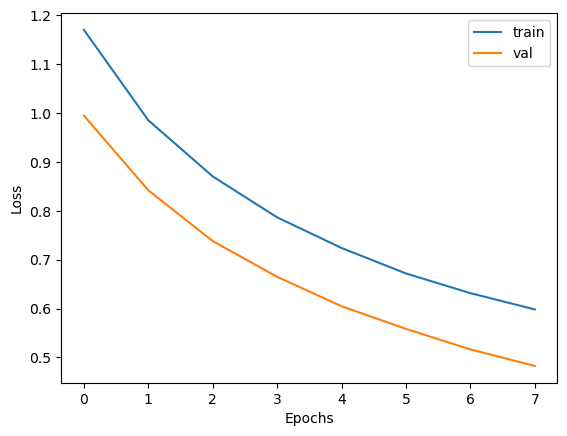

In [ ]:
#plot the training and validation losses
train_losses3 = train_losses

plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

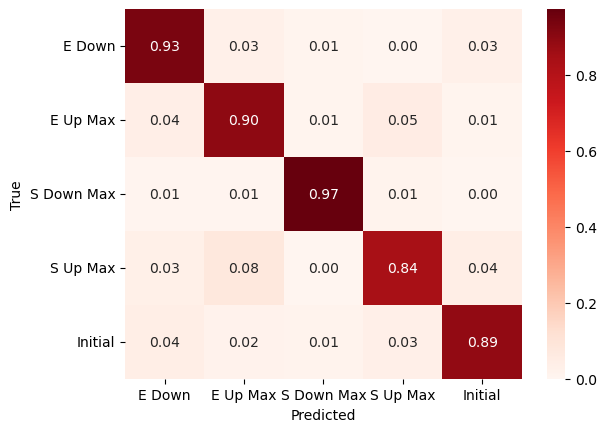

              precision    recall  f1-score   support

      E Down       0.89      0.93      0.91       294
    E Up Max       0.86      0.90      0.88       258
  S Down Max       0.93      0.97      0.95       152
    S Up Max       0.90      0.84      0.87       290
     Initial       0.93      0.89      0.91       343

    accuracy                           0.90      1337
   macro avg       0.90      0.91      0.90      1337
weighted avg       0.90      0.90      0.90      1337



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(efficientnet_b0, val_loader, classes_names)

## EfficientNet-B0 Testing

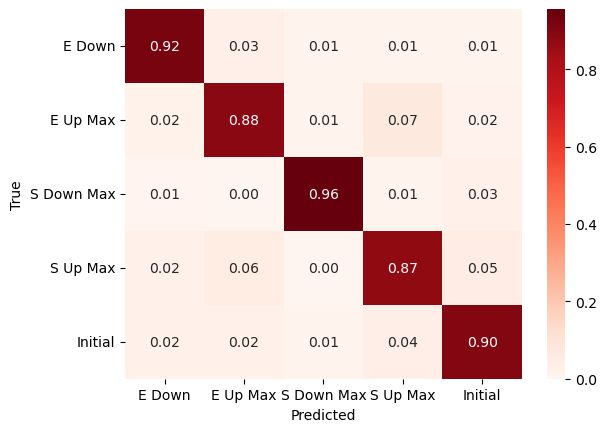

              precision    recall  f1-score   support

      E Down       0.93      0.92      0.93       293
    E Up Max       0.87      0.88      0.88       260
  S Down Max       0.93      0.96      0.94       156
    S Up Max       0.87      0.87      0.87       287
     Initial       0.92      0.90      0.91       342

    accuracy                           0.90      1338
   macro avg       0.90      0.91      0.91      1338
weighted avg       0.90      0.90      0.90      1338



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(efficientnet_b0, test_loader, classes_names)

# SqueezNet

## SqueezNet Training

In [ ]:
# Load the pre-trained SqueezeNet model
SqueezNet_1 = models.squeezenet1_0(pretrained=True)

# Replace the final classification layer
num_ftrs = SqueezNet_1.classifier[1].in_channels
SqueezNet_1.classifier[1] = nn.Conv2d(num_ftrs, 5, kernel_size=(1, 1))


SqueezNet_1 = SqueezNet_1.to(device)

/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fallathh/miniconda3/envs/IbexGPU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SqueezNet_1.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(SqueezNet_1, criterion, optimizer, train_loader, val_loader, 10)

Epoch 1/10 | Train Loss: 0.5531 | Val Loss: 0.1146 | Val Accuracy: 0.9693
Epoch 2/10 | Train Loss: 0.0981 | Val Loss: 0.0208 | Val Accuracy: 0.9940
Epoch 3/10 | Train Loss: 0.0284 | Val Loss: 0.0240 | Val Accuracy: 0.9918
Epoch 4/10 | Train Loss: 0.0273 | Val Loss: 0.0141 | Val Accuracy: 0.9955
Epoch 5/10 | Train Loss: 0.0190 | Val Loss: 0.0026 | Val Accuracy: 0.9993
Epoch 6/10 | Train Loss: 0.0010 | Val Loss: 0.0023 | Val Accuracy: 0.9993
Epoch 7/10 | Train Loss: 1.1942 | Val Loss: 0.1980 | Val Accuracy: 0.9334
Epoch 8/10 | Train Loss: 0.5932 | Val Loss: 0.0294 | Val Accuracy: 0.9925
Epoch 9/10 | Train Loss: 0.0736 | Val Loss: 0.0159 | Val Accuracy: 0.9948
Epoch 10/10 | Train Loss: 0.0113 | Val Loss: 0.0014 | Val Accuracy: 1.0000


Finished Training and the best accuracy is: 100.0000


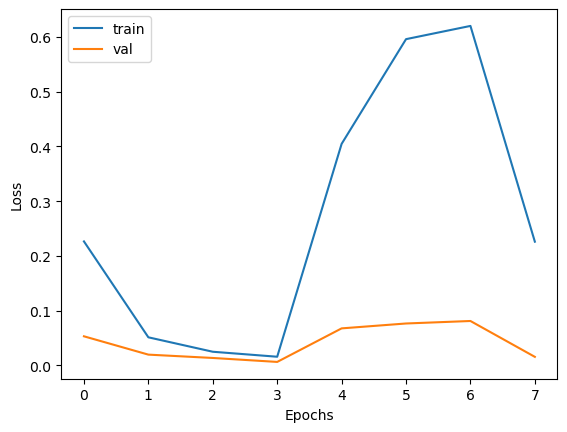

In [ ]:
#plot the training and validation losses
train_losses4 = train_losses

plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

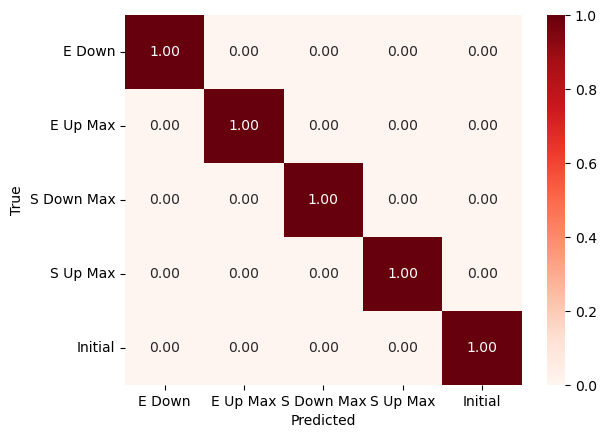

              precision    recall  f1-score   support

      E Down       1.00      1.00      1.00       294
    E Up Max       1.00      1.00      1.00       258
  S Down Max       1.00      1.00      1.00       152
    S Up Max       1.00      1.00      1.00       290
     Initial       1.00      1.00      1.00       343

    accuracy                           1.00      1337
   macro avg       1.00      1.00      1.00      1337
weighted avg       1.00      1.00      1.00      1337



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(SqueezNet_1, val_loader, classes_names)

## SqueezNet Testing  

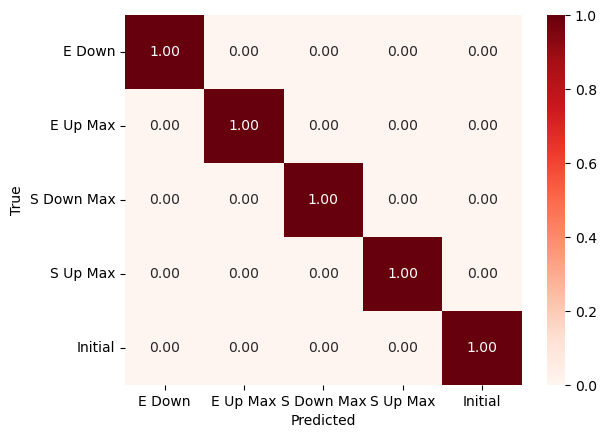

              precision    recall  f1-score   support

      E Down       1.00      1.00      1.00       293
    E Up Max       1.00      1.00      1.00       260
  S Down Max       1.00      1.00      1.00       156
    S Up Max       1.00      1.00      1.00       287
     Initial       1.00      1.00      1.00       342

    accuracy                           1.00      1338
   macro avg       1.00      1.00      1.00      1338
weighted avg       1.00      1.00      1.00      1338



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(SqueezNet_1, test_loader, classes_names)

# Displaying all the Losses Together

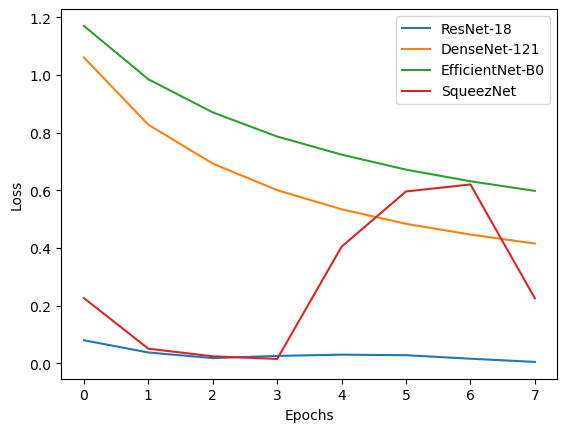

In [ ]:
#plot the training and validation losses
plt.plot(np.convolve(train_losses1, np.ones(3)/3, mode='valid'), label='ResNet-18')
plt.plot(np.convolve(train_losses2, np.ones(3)/3, mode='valid'), label='DenseNet-121')
plt.plot(np.convolve(train_losses3, np.ones(3)/3, mode='valid'), label='EfficientNet-B0')
plt.plot(np.convolve(train_losses4, np.ones(3)/3, mode='valid'), label='SqueezNet')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()